# Info
Purpose:

    Describe the details ...

Input:

    arguments

Output:

    Figure and save files

Keywords:

    none

Dependencies:

    - load_utils.py
    - matplotlib
    - numpy
    - Sp_parameters
    - write_utils
    - path_utils
    - hdf5storage
    - scipy

Needed Files:
  - file.rc : for consistent creation of look of matplotlib figures
  - ...

Modification History:

    Written: Samuel LeBlanc, Santa Cruz, CA, 2022-03-17
    Modified:


# Prepare python environment

In [3]:
import numpy as np
import Sp_parameters as Sp
import load_utils as lu
import write_utils as wu
from path_utils import getpath
import hdf5storage as hs
import scipy.io as sio
import matplotlib.pyplot as plt
%matplotlib notebook
import os
import glob

In [361]:
from datetime import datetime,timedelta
import scipy.stats as st

In [61]:
import sys
if sys.version_info[0] < 3: 
    from StringIO import StringIO, BytesIO
else:
    from io import StringIO, BytesIO

In [9]:
name = 'rooftop'
vv = 'v1'
fp = getpath(name)


Return path named:  rooftop /data/sunsat/rooftop/


# Load files

## Load 4STAR gas summary

In [12]:
files = glob.glob(fp + '/**/[!4STARB]*gas_summary*.mat', recursive=True)

In [13]:
files

['/data/sunsat/rooftop/Winter_2022/data_processed/gas_summary/20220215_gas_summary.mat',
 '/data/sunsat/rooftop/Winter_2022/data_processed/gas_summary/20220208_gas_summary.mat',
 '/data/sunsat/rooftop/Winter_2022/data_processed/gas_summary/20220216_gas_summary.mat',
 '/data/sunsat/rooftop/Spring_2021/data_processed/gas_summary/20210401_gas_summary.mat',
 '/data/sunsat/rooftop/Spring_2021/data_processed/gas_summary/20190821_gas_summary.mat',
 '/data/sunsat/rooftop/Spring_2021/data_processed/gas_summary/20210331_gas_summary.mat',
 '/data/sunsat/rooftop/Spring_2021/data_processed/gas_summary/20210330_gas_summary.mat',
 '/data/sunsat/rooftop/Fall_2020/data_processed/gas_summary/20201112_gas_summary.mat',
 '/data/sunsat/rooftop/Fall_2020/data_processed/gas_summary/20200929_gas_summary.mat',
 '/data/sunsat/rooftop/Fall_2020/data_processed/gas_summary/20201104_gas_summary.mat',
 '/data/sunsat/rooftop/Fall_2020/data_processed/gas_summary/20201001_gas_summary.mat',
 '/data/sunsat/rooftop/Fall_2

In [22]:
gas = {}
for f in files:
    g = sio.loadmat(f)
    daystr = f.replace('/','_').split('_')[-3]
    gas[daystr] = g

In [25]:
gas['20220208'].keys()

dict_keys(['__header__', '__version__', '__globals__', 'no2_molec_cm2', 'no2err_molec_cm2', 'no2DU', 'no2resiDU', 'o3DU', 'o3resiDU', 'hcoh_DU', 'hcohresi', 'cwv', 'cwv_std', 'lat', 'lon', 'alt', 'pst', 'sza', 'm_aero', 'm_o3', 'm_no2', 'tUTC'])

In [159]:
gas['20220208']['tUTC']

array([[16.92862389],
       [16.92926194],
       [16.92956583],
       ...,
       [23.87420556],
       [23.87476111],
       [23.87528639]])

In [186]:
kg = list(gas.keys())
kg.sort()

In [211]:
s = {'day':[],'time':[],'tUTC':[],'no2DU':[],'no2resiDU':[],'o3DU':[],'o3resiDU':[]}
for d in kg:
    for kk in ['tUTC','no2DU','no2resiDU','o3DU','o3resiDU']:
        s[kk] = np.append(s[kk],gas[d][kk][:,0])
    s['day'] = np.append(s['day'],[d]*len(gas[d][kk][:,0]))

In [266]:
s['time'] = pd.to_datetime(s['day']).to_numpy() + [np.timedelta64(timedelta(hours=tt)) for tt in s['tUTC']]

In [267]:
s['time']

array(['2019-08-21T17:05:17.312002000', '2019-08-21T17:05:19.328004000',
       '2019-08-21T17:05:20.406000000', ...,
       '2022-02-16T00:47:28.999996000', '2022-02-16T00:47:30.499998000',
       '2022-02-16T00:47:32.202997000'], dtype='datetime64[ns]')

## Load Pandora

### load files from internet

In [26]:
import requests

In [38]:
url_base = 'http://data.pandonia-global-network.org/MountainViewCA/Pandora34s1/L2/'
url_O3 = url_base+'Pandora34s1_MountainViewCA_L2Tot_rout0p1-7.txt'
url_NO2 = url_base+'Pandora34s1_MountainViewCA_L2Tot_rnvs1p1-7.txt'
url_NO2_trop = url_base+'Pandora34s1_MountainViewCA_L2Trop_rnvh1p1-7.txt'

In [41]:
ro3 = requests.get(url_O3,stream=True)
fo3 = []
for chunk in ro3.iter_content(chunk_size=1024): 
    fo3.append(chunk)

In [43]:
rno2 = requests.get(url_NO2,stream=True)
fno2 = []
for chunk in rno2.iter_content(chunk_size=1024): 
    fno2.append(chunk)

### convert files to something easier to handle

In [44]:
import pandas as pd

#### Ozone

In [93]:
o3data = BytesIO(b''.join(fo3))

In [132]:
o3data.seek(0)
o3header = []
for i in range(66):
    o3header.append(o3data.readline())
print(*o3header,sep='\n')

b'File name: Pandora34s1_MountainViewCA_L2Tot_rout0p1-7.txt\n'
b'File generation date: 20220321T082259Z\n'
b'Data description: Level 2 total columns file\n'
b'Data file version: rout0p1-7\n'
b'Data product status: Ozone data are official, Sulfur dioxide data are unusable\n'
b'Local principal investigator: Nader Abuhassan\n'
b'Network principal investigator: Alexander Cede\n'
b'Instrument type: Pandora\n'
b'Instrument number: 34\n'
b'Spectrometer number: 1\n'
b'Processing software version used: BlickP v1.7.16\n'
b'Full location name: Ames Research Center\n'
b'Short location name: MountainViewCA\n'
b'Country of location: United States\n'
b'Location latitude [deg]: 37.4200\n'
b'Location longitude [deg]: -122.0568\n'
b'Location altitude [m]: 50\n'
b'Data start time: 20191121T221159Z\n'
b'Data end time: NONE\n'
b'Data caveats: None\n'
b'---------------------------------------------------------------------------------------\n'
b'Column 1: UT date and time for center of measurement, yyyymmddT

In [143]:
col_name = ['Time','doy_jan2000','measT','sza','saz','lza','laz','o3_du','unc_o3_du','m_o3','diff_corr','qa_o3','sumi2_dq1',
            'sumi_dq2','so2_du','unc_so2_du','m_so2','diff_corr_so2','qa_no2','sumi2_so2_dq1','sumi2_so2_dq2',
            'fit_resi','resi_rms','expmeas_resi_rms','expinst_resi_rms','mean_val','Pres_mbar','dat_proc',
            'cal_version','cal_val_date','L2fit_QA','sumi2_L2fit_dq1','sumi2_L2fit_dq2','L1_QA','sumi2_L1_dq1',
            'sumi2_L1_dq2','effT_wav','resi_straylight','L1_wv_shift','wv_shift_fit','int','darkcount','pos_filter1','pos_filter2']

In [144]:
for i,h in enumerate(o3header[21:]):
    print(i,'\033[1m'+col_name[i]+'\033[0m',h)

0 Time b'Column 1: UT date and time for center of measurement, yyyymmddThhmmssZ (ISO 8601)\n'
1 doy_jan2000 b'Column 2: Fractional days since 1-Jan-2000 UT midnight for center of measurement\n'
2 measT b'Column 3: Effective duration of measurement in seconds\n'
3 sza b'Column 4: Solar zenith angle for center of measurement in degree\n'
4 saz b'Column 5: Solar azimuth for center of measurement in degree, 0=north, increases clockwise\n'
5 lza b'Column 6: Lunar zenith angle for center of measurement in degree\n'
6 laz b'Column 7: Lunar azimuth for center of measurement in degree, 0=north, increases clockwise\n'
7 o3_du b'Column 8: Ozone total vertical column amount [Dobson Units], -9e99=retrieval not successful\n'
8 unc_o3_du b'Column 9: Uncertainty of ozone total vertical column amount [Dobson Units] based on measured uncertainty, -8=retrieval not successful, -1=cross section is zero in this wavelength range, -3=spectral fitting was done, but no uncertainty could be retrieved\n'
9 m_o3 b

IndexError: list index out of range

In [145]:
o3data.seek(0)
pdo3 = pd.read_csv(o3data,encoding='unicode_escape',header=66,delimiter=' ',names=col_name)

In [146]:
pdo3

,Time,doy_jan2000,measT,sza,saz,lza,laz,o3_du,unc_o3_du,m_o3,...,sumi2_L1_dq1,sumi2_L1_dq2,effT_wav,resi_straylight,L1_wv_shift,wv_shift_fit,int,darkcount,pos_filter1,pos_filter2
0,20191121T221326Z,7264.92600,26.09,66.12,215.93,89.91,276.83,293.36,0.11227,2.428,...,0,0,25.68,0.23,-0.01140,-0.04927,20.9,237,1,5
1,20191121T221453Z,7264.92701,26.62,66.29,216.25,90.19,277.04,293.04,0.11232,2.444,...,0,0,25.68,0.25,-0.01147,-0.04921,21.2,234,1,5
2,20191121T221618Z,7264.92800,25.86,66.46,216.57,90.47,277.24,292.97,0.11349,2.460,...,0,0,25.68,0.23,-0.01111,-0.04953,21.5,232,1,5
3,20191121T222329Z,7264.93298,26.80,67.33,218.14,91.85,278.27,292.34,0.11513,2.544,...,0,0,25.68,0.25,-0.01178,-0.05119,22.6,223,1,5
4,20191121T222455Z,7264.93398,27.79,67.50,218.46,92.12,278.48,292.33,0.11538,2.563,...,0,0,25.68,0.24,-0.01158,-0.05101,22.7,222,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122316,20220321T010320.9Z,8115.04399,50.03,75.65,258.93,137.70,63.74,327.40,0.19314,3.839,...,0,0,26.51,0.22,0.00001,-0.06154,62.6,156,1,5
122317,20220321T010840.9Z,8115.04770,50.00,76.69,259.79,136.80,65.01,326.59,0.17228,4.100,...,0,0,26.41,0.24,-0.00049,-0.06502,66.2,147,1,5
122318,20220321T011417.0Z,8115.05159,50.08,77.79,260.68,135.85,66.31,324.92,0.20106,4.415,...,0,0,26.41,0.23,-0.00051,-0.06314,79.1,123,1,5
122319,20220321T013801.6Z,8115.06807,50.30,82.46,264.40,131.71,71.43,318.55,0.83321,6.462,...,0,0,26.32,0.42,-0.00064,-0.07067,461.3,21,1,5


In [147]:
pdo3['datetime'] = pd.to_datetime(pdo3['Time'])

#### NO2

In [149]:
no2data = BytesIO(b''.join(fno2))

In [152]:
no2data.seek(0)
no2header = []
for i in range(59):
    no2header.append(no2data.readline())
print(*no2header,sep='\n')

b'File name: Pandora34s1_MountainViewCA_L2Tot_rnvs1p1-7.txt\n'
b'File generation date: 20220321T082300Z\n'
b'Data description: Level 2 total columns file\n'
b'Data file version: rnvs1p1-7\n'
b'Data product status: Nitrogen dioxide data are official\n'
b'Local principal investigator: Nader Abuhassan\n'
b'Network principal investigator: Alexander Cede\n'
b'Instrument type: Pandora\n'
b'Instrument number: 34\n'
b'Spectrometer number: 1\n'
b'Processing software version used: BlickP v1.7.16\n'
b'Full location name: Ames Research Center\n'
b'Short location name: MountainViewCA\n'
b'Country of location: United States\n'
b'Location latitude [deg]: 37.4200\n'
b'Location longitude [deg]: -122.0568\n'
b'Location altitude [m]: 50\n'
b'Data start time: 20191121T221109Z\n'
b'Data end time: NONE\n'
b'Data caveats: None\n'
b'---------------------------------------------------------------------------------------\n'
b'Column 1: UT date and time for center of measurement, yyyymmddThhmmssZ (ISO 8601)\n'
b

In [154]:
col_name_no2 = ['Time','doy_jan2000','measT','sza','saz','lza','laz',
                'no2_du','unc_no2_du','m_no2','diff_corr_no2','qa_no2','sumi2_no2_dq1','sumi_no2_dq2',
                'fit_resi','resi_rms','expmeas_resi_rms','expinst_resi_rms','mean_val','Pres_mbar','dat_proc',
            'cal_version','cal_val_date','L2fit_QA','sumi2_L2fit_dq1','sumi2_L2fit_dq2','L1_QA','sumi2_L1_dq1',
            'sumi2_L1_dq2','effT_wav','resi_straylight','L1_wv_shift','wv_shift_fit','int','darkcount','pos_filter1','pos_filter2']

In [155]:
for i,h in enumerate(no2header[21:]):
    print('\033[1m'+col_name_no2[i]+'\033[0m',h)

Time b'Column 1: UT date and time for center of measurement, yyyymmddThhmmssZ (ISO 8601)\n'
doy_jan2000 b'Column 2: Fractional days since 1-Jan-2000 UT midnight for center of measurement\n'
measT b'Column 3: Effective duration of measurement in seconds\n'
sza b'Column 4: Solar zenith angle for center of measurement in degree\n'
saz b'Column 5: Solar azimuth for center of measurement in degree, 0=north, increases clockwise\n'
lza b'Column 6: Lunar zenith angle for center of measurement in degree\n'
laz b'Column 7: Lunar azimuth for center of measurement in degree, 0=north, increases clockwise\n'
no2_du b'Column 8: Nitrogen dioxide total vertical column amount [Dobson Units], -9e99=retrieval not successful\n'
unc_no2_du b'Column 9: Uncertainty of nitrogen dioxide total vertical column amount [Dobson Units] based on measured uncertainty, -8=retrieval not successful, -1=cross section is zero in this wavelength range, -3=spectral fitting was done, but no uncertainty could be retrieved\n'
m_

IndexError: list index out of range

In [156]:
no2data.seek(0)
pdno2 = pd.read_csv(no2data,encoding='unicode_escape',header=59,delimiter=' ',names=col_name_no2)

In [157]:
pdno2['datetime'] = pd.to_datetime(pdno2['Time'])

In [158]:
pdno2

,Time,doy_jan2000,measT,sza,saz,lza,laz,no2_du,unc_no2_du,m_no2,...,sumi2_L1_dq2,effT_wav,resi_straylight,L1_wv_shift,wv_shift_fit,int,darkcount,pos_filter1,pos_filter2,datetime
0,20191121T221239Z,7264.92546,19.47,66.03,215.76,89.76,276.72,0.44002,0.000918,2.444,...,0,25.68,1.00,-0.00199,-0.00149,8.4,433,3,4,2019-11-21 22:12:39+00:00
1,20191121T221407Z,7264.92648,21.01,66.20,216.08,90.05,276.93,0.44762,0.000932,2.461,...,0,25.68,1.00,-0.00151,-0.00081,8.5,429,3,4,2019-11-21 22:14:07+00:00
2,20191121T221532Z,7264.92746,19.35,66.37,216.40,90.32,277.13,0.43500,0.000917,2.477,...,0,25.68,1.00,-0.00142,-0.00097,8.5,429,3,4,2019-11-21 22:15:32+00:00
3,20191121T221659Z,7264.92847,20.78,66.54,216.72,90.60,277.34,0.44617,0.000913,2.493,...,2,25.68,0.93,-0.00136,-0.00088,8.6,0,3,4,2019-11-21 22:16:59+00:00
4,20191121T222242Z,7264.93244,19.78,67.23,217.97,91.70,278.16,0.44165,0.000996,2.564,...,0,25.68,1.00,-0.00140,-0.00117,8.7,424,3,4,2019-11-21 22:22:42+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404463,20220321T015133.0Z,8115.07747,8.48,85.13,266.48,129.29,74.11,0.23458,0.000713,10.058,...,0,26.21,1.01,-0.00824,-0.00040,16.1,99,1,4,2022-03-21 01:51:33+00:00
404464,20220321T015141.7Z,8115.07757,8.53,85.16,266.51,129.27,74.14,0.23322,0.000708,10.101,...,0,26.21,1.01,-0.00839,-0.00056,16.1,99,1,4,2022-03-21 01:51:41.700000+00:00
404465,20220321T020409.8Z,8115.08622,50.01,87.63,268.41,127.01,76.48,0.18275,-3.000000,15.239,...,0,26.11,1.48,-0.00457,-0.00192,64.0,152,1,4,2022-03-21 02:04:09.800000+00:00
404466,20220321T020711.9Z,8115.08833,50.15,88.24,268.87,126.45,77.04,0.18556,-3.000000,16.886,...,0,26.11,1.90,-0.01825,-0.00995,114.2,85,1,4,2022-03-21 02:07:11.900000+00:00


# Plot out data

## Plot time series

<IPython.core.display.Javascript object>


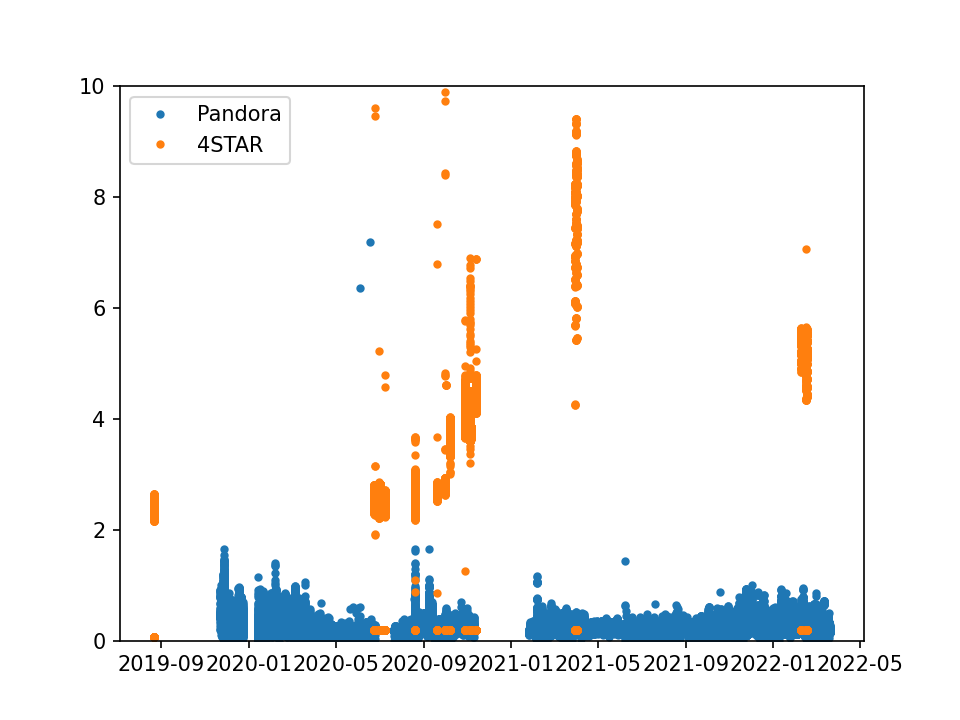

In [270]:
plt.figure()
plt.plot(pdno2['datetime'],pdno2['no2_du'],'.',label='Pandora')
plt.plot(s['time'],s['no2DU'],'.',label='4STAR')
plt.ylim(0,10)
plt.legend()

<IPython.core.display.Javascript object>


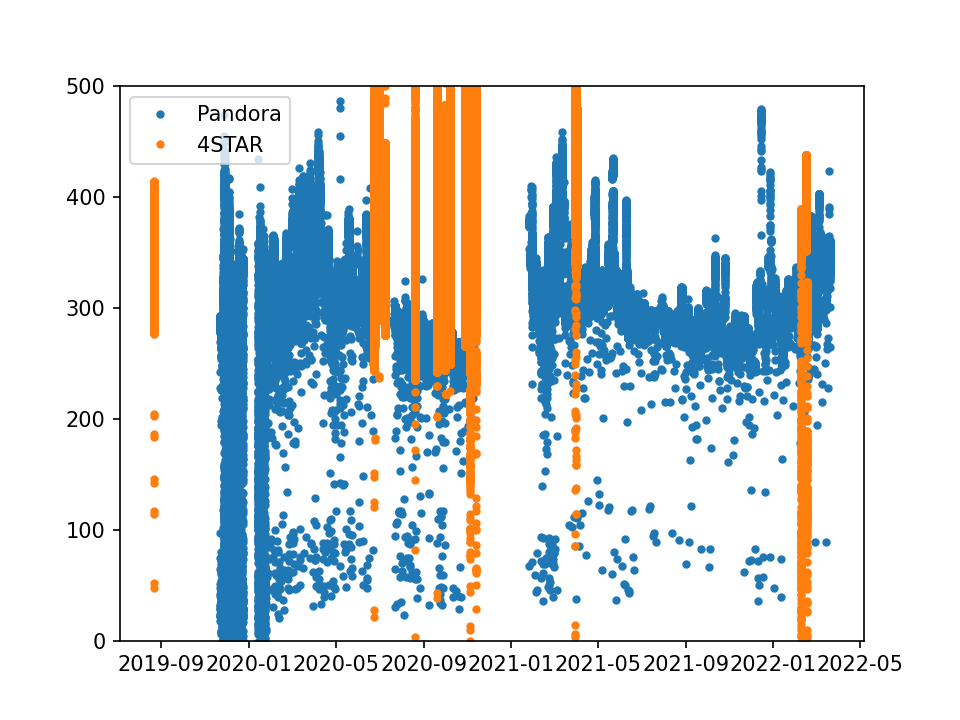

In [273]:
plt.figure()
plt.plot(pdo3['datetime'],pdo3['o3_du'],'.',label='Pandora')
plt.plot(s['time'],s['o3DU'],'.',label='4STAR')
plt.ylim(0,500)
plt.legend()

## one to one plot, matching measurement times

### Ozone

In [347]:
spd = pd.DataFrame(s)
spd['datetime'] = pd.to_datetime(s['time'],utc=True)
spd2 = spd.sort_values(by='datetime')

In [320]:
fullpd = pd.merge_asof(spd2,pdo3,direction='nearest')

In [323]:
fullpd['o3DU'][fullpd['o3DU']<0.0] = np.nan

<ipython-input-323-e085c9f2dfe0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fullpd['o3DU'][fullpd['o3DU']<0.0] = np.nan


In [327]:
fullpd['o3_du'][fullpd['qa_o3']>10] = np.nan

<ipython-input-327-3ad807824a79>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fullpd['o3_du'][fullpd['qa_o3']>10] = np.nan


<IPython.core.display.Javascript object>


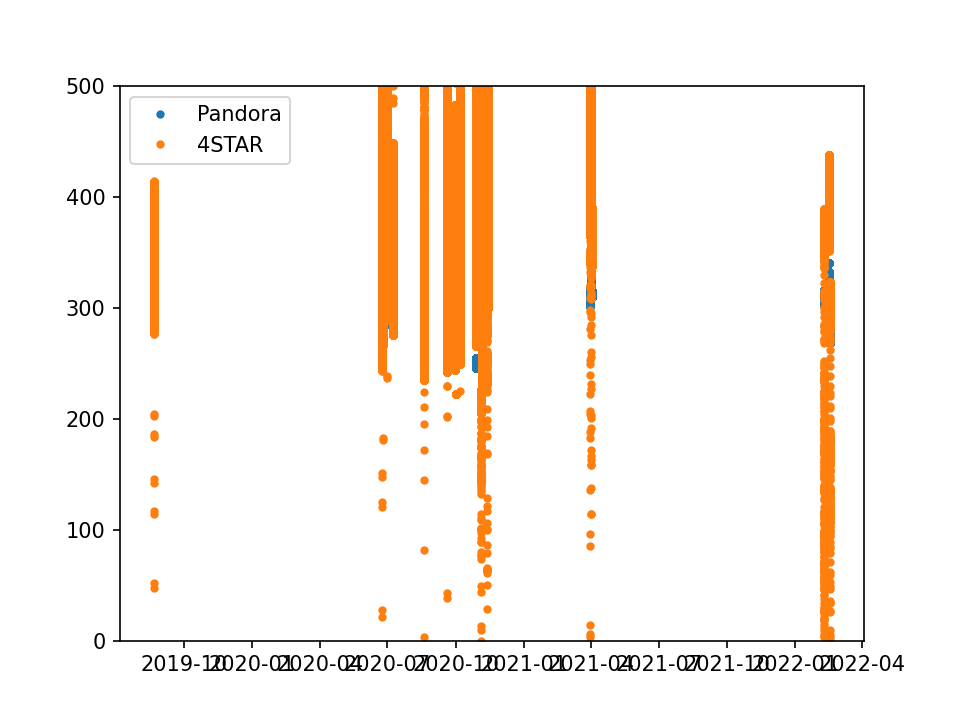

In [329]:
plt.figure()
plt.plot(fullpd['datetime'],fullpd['o3_du'],'.',label='Pandora')
plt.plot(fullpd['datetime'],fullpd['o3DU'],'.',label='4STAR')
plt.ylim(0,500)
plt.legend()

In [337]:
import plotting_utils as pu
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [343]:
fl = np.isfinite(fullpd['o3_du']) & np.isfinite(fullpd['o3DU'])

In [364]:
r = st.spearmanr(fullpd['o3_du'],fullpd['o3DU'],nan_policy='omit')

In [367]:
r.correlation

0.5375012765846725

In [372]:
rmse = mean_squared_error(fullpd['o3_du'][fl],fullpd['o3DU'][fl],squared=True)
rmse

In [375]:
mae = mean_absolute_error(fullpd['o3_du'][fl],fullpd['o3DU'][fl])
mae

In [451]:
import importlib
importlib.reload(pu)

<module 'plotting_utils' from '/home/sam/python_codes/plotting_utils.py'>

In [387]:
from Sp_parameters import doublenanmask, nanmasked
from scipy import odr
from linfit import linfit

In [388]:
x = fullpd['o3_du']
y = fullpd['o3DU']
x_err = fullpd['unc_o3_du']
y_err = fullpd['o3resiDU']

In [389]:
xn,yn,mask = doublenanmask(x,y,return_mask=True)

In [390]:
model = odr.Model(lin)
dat = odr.RealData(xn,yn,sx=x_err[mask],sy=y_err[mask])

In [391]:
c,cm = linfit(xn,yn)
p = np.array([c[1],c[0]])

In [417]:
imask = mask & (y_err>0)

In [435]:
ri = np.corrcoef(x_err[imask],y_err[imask])[0,1]

In [442]:
a_bivar, b_bivar, S, cov = pu.bivariate_fit(xn,yn,x_err[imask],y_err[imask],b0=p[1],ri=ri**2)

In [443]:
a_bivar

-239.62155478503934

In [444]:
b_bivar

1.9896480005361032

In [445]:
S

2784015541.484368

In [449]:
np.sqrt(cov[1,1])*b_bivar

0.03470018645758508

<IPython.core.display.Javascript object>


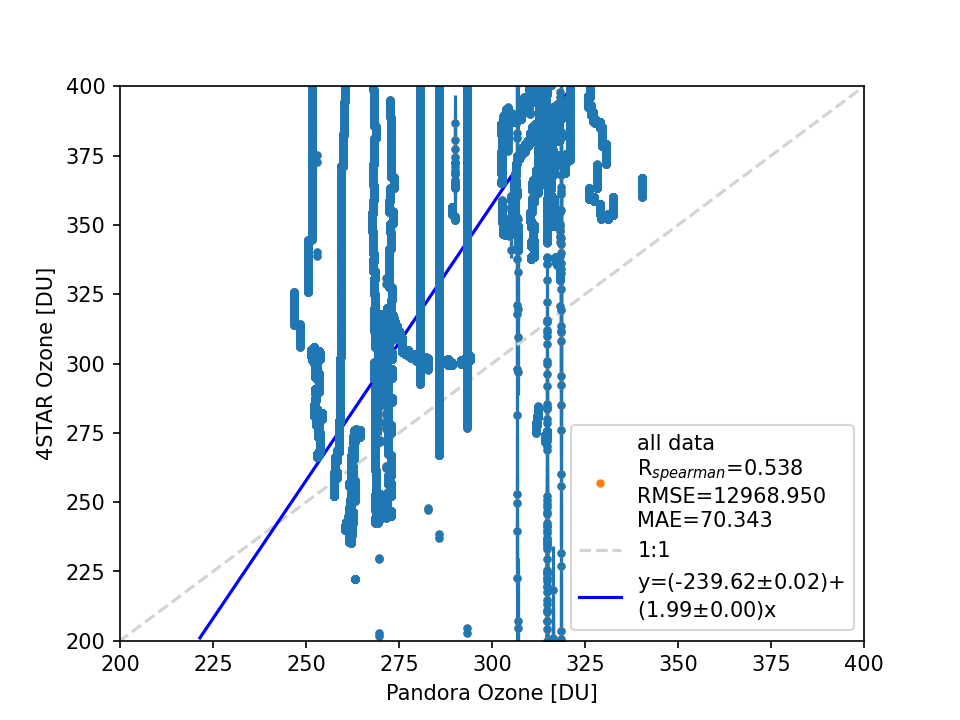

In [441]:
plt.figure()
plt.errorbar(fullpd['o3_du'],fullpd['o3DU'],xerr=fullpd['unc_o3_du'],yerr=fullpd['o3resiDU'],marker='.',ls='')
plt.plot(fullpd['o3_du'],fullpd['o3DU'],'.',
         label='all data\nR$_{{spearman}}$={:1.3f}\nRMSE={:1.3f}\nMAE={:1.3f}'.format(r.correlation,rmse,mae))
plt.plot([0,500],[0,500],'--',color='lightgrey',label='1:1')
pu.plot_lin(fullpd['o3_du'],fullpd['o3DU'],x_err=fullpd['unc_o3_du'],y_err=fullpd['o3resiDU'],use_method='york')
plt.legend()
plt.ylabel('4STAR Ozone [DU]')
plt.xlabel('Pandora Ozone [DU]')
plt.ylim(200,400)
plt.xlim(200,400)
plt.savefig(fp+'Winter_2022/plots/4STAR_to_Pandora_O3.png',dpi=600,transparent=True)

<IPython.core.display.Javascript object>


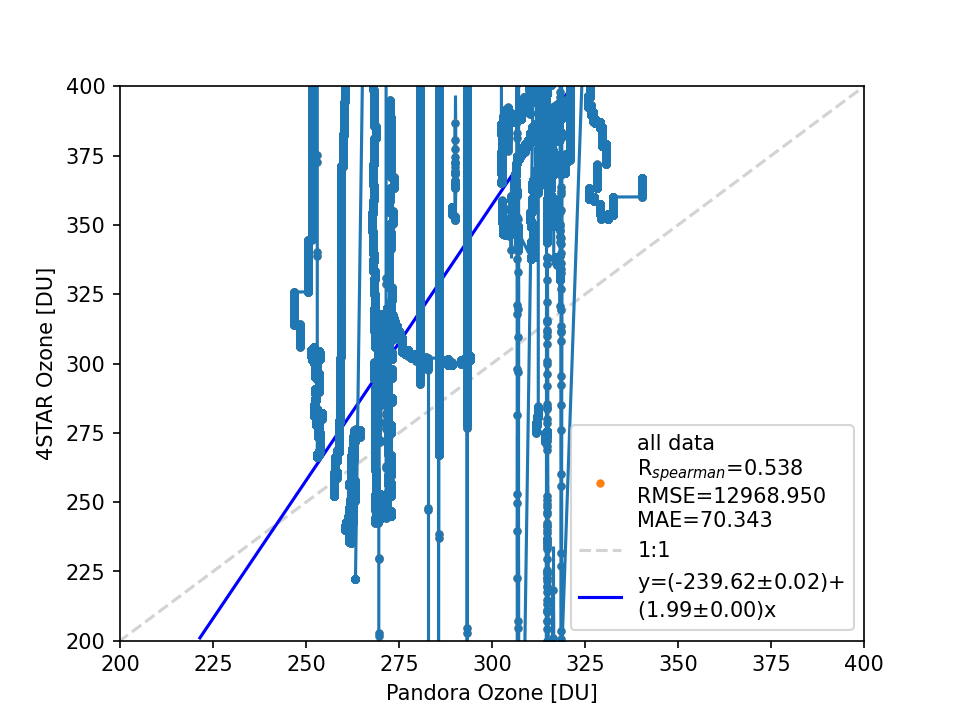

In [401]:
plt.figure()
plt.errorbar(fullpd['o3_du'],fullpd['o3DU'],xerr=fullpd['unc_o3_du'],yerr=fullpd['o3resiDU'],marker='.',ls='')
plt.plot(fullpd['o3_du'],fullpd['o3DU'],'.',
         label='all data\nR$_{{spearman}}$={:1.3f}\nRMSE={:1.3f}\nMAE={:1.3f}'.format(r.correlation,rmse,mae))
plt.plot([0,500],[0,500],'--',color='lightgrey',label='1:1')
pu.plot_lin(fullpd['o3_du'],fullpd['o3DU'],x_err=fullpd['unc_o3_du'],y_err=fullpd['o3resiDU'],use_method='york')
plt.legend()
plt.ylabel('4STAR Ozone [DU]')
plt.xlabel('Pandora Ozone [DU]')
plt.ylim(200,400)
plt.xlim(200,400)
plt.savefig(fp+'Winter_2022/plots/4STAR_to_Pandora_O3.png',dpi=600,transparent=True)

### NO2

In [348]:
spd = pd.DataFrame(s)
spd['datetime'] = pd.to_datetime(s['time'],utc=True)
spd2 = spd.sort_values(by='datetime')

In [349]:
fullpdn = pd.merge_asof(spd2,pdno2,direction='nearest')

In [350]:
fullpdn['no2DU'][fullpdn['no2DU']<0.0] = np.nan

<ipython-input-350-f0413335cea4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fullpd['no2DU'][fullpd['no2DU']<0.0] = np.nan


In [352]:
fullpdn['no2_du'][fullpdn['qa_no2']>10] = np.nan

<ipython-input-352-c8f31cd4fb6b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fullpdn['no2_du'][fullpdn['qa_no2']>10] = np.nan


<IPython.core.display.Javascript object>


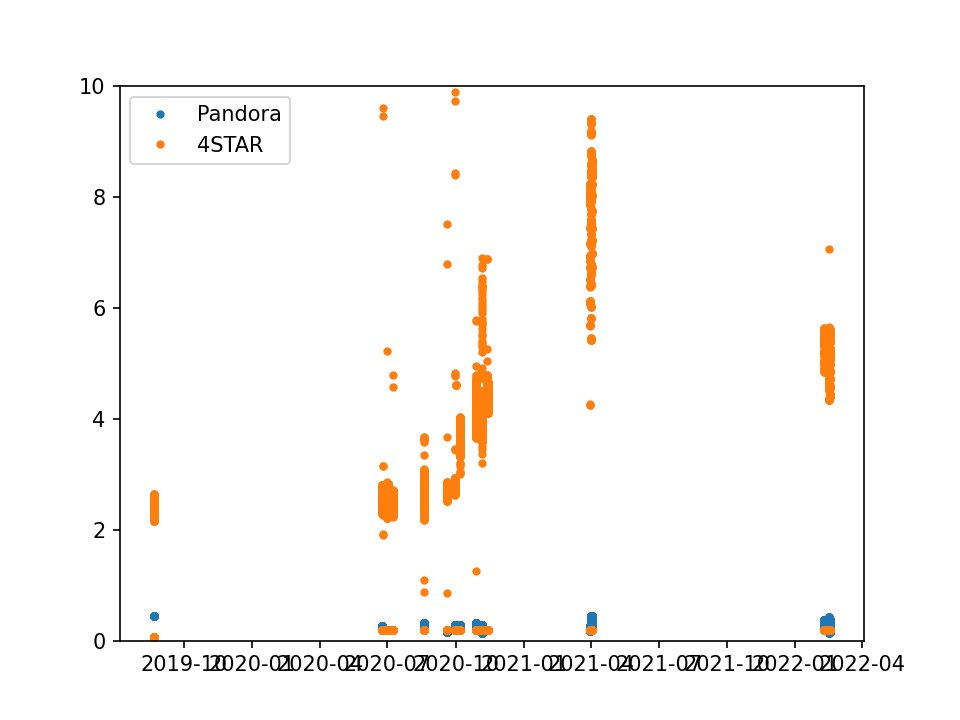

In [354]:
plt.figure()
plt.plot(fullpdn['datetime'],fullpdn['no2_du'],'.',label='Pandora')
plt.plot(fullpdn['datetime'],fullpdn['no2DU'],'.',label='4STAR')
plt.ylim(0,10)
plt.legend()

In [355]:
import plotting_utils as pu

In [356]:
fln = np.isfinite(fullpdn['no2_du']) & np.isfinite(fullpdn['no2DU'])

<IPython.core.display.Javascript object>


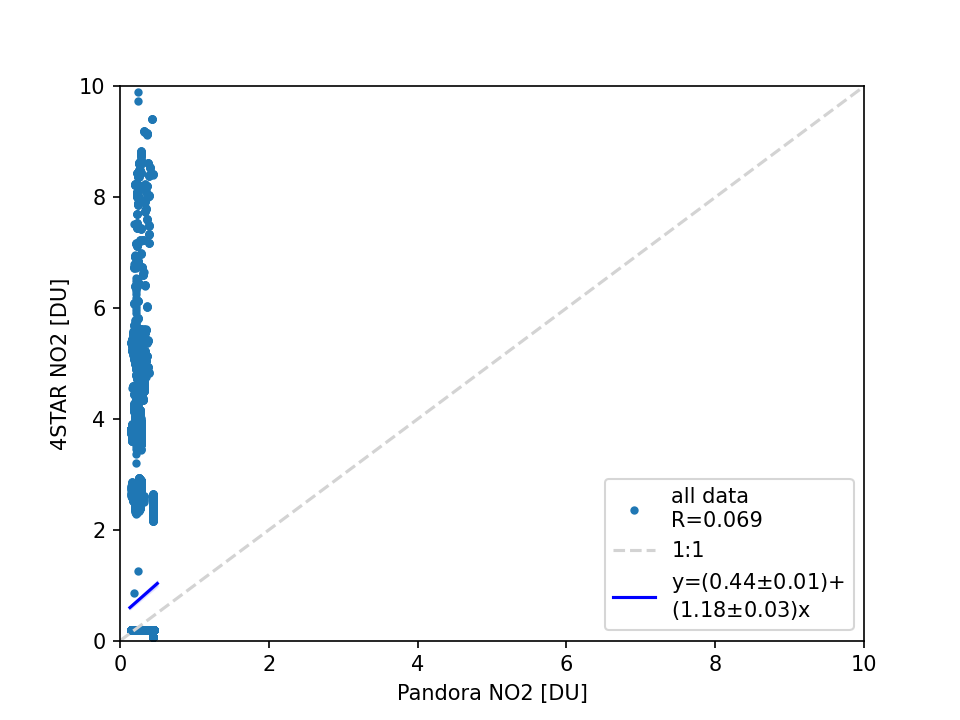

In [359]:
plt.figure()
plt.plot(fullpdn['no2_du'],fullpdn['no2DU'],'.',
         label='all data\nR={:1.3f}'.format(np.corrcoef(fullpdn['no2_du'][fln],fullpdn['no2DU'][fln])[0,1]))
plt.plot([0,10],[0,10],'--',color='lightgrey',label='1:1')
pu.plot_lin(fullpdn['no2_du'],fullpdn['no2DU'])
plt.legend()
plt.ylabel('4STAR NO2 [DU]')
plt.xlabel('Pandora NO2 [DU]')
plt.ylim(0,10)
plt.xlim(0,10)

plt.savefig(fp+'Winter_2022/plots/4STAR_to_Pandora_NO2.png',dpi=600,transparent=True)

<IPython.core.display.Javascript object>


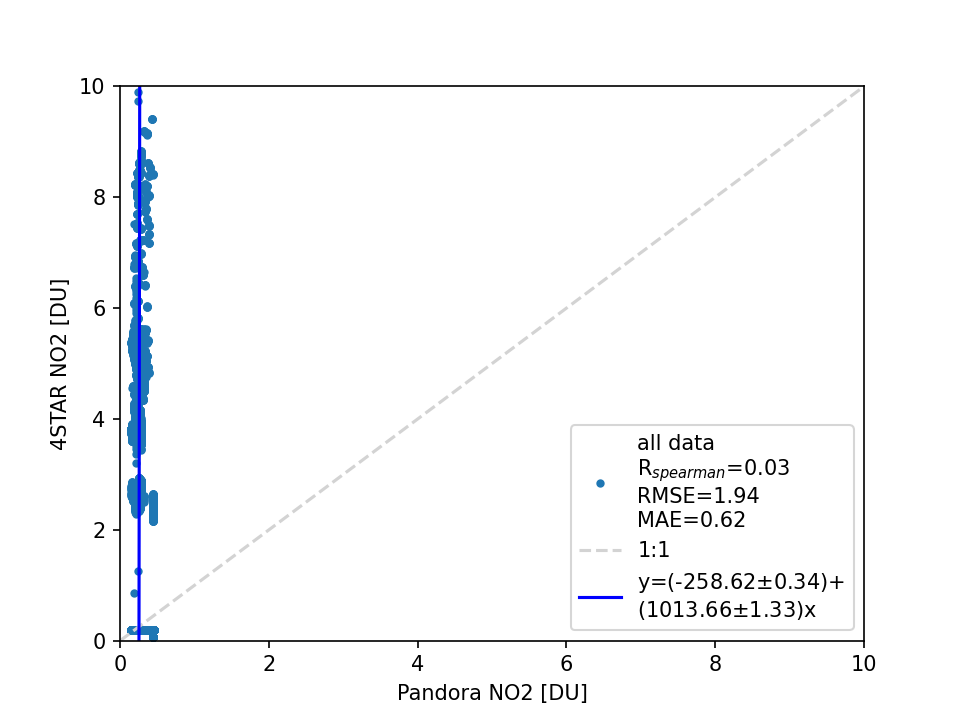

In [453]:
plt.figure()
plt.plot(fullpdn['no2_du'],fullpdn['no2DU'],'.',
         label='all data\n'+pu.stats_label(fullpdn['no2_du'],fullpdn['no2DU']))
plt.plot([0,10],[0,10],'--',color='lightgrey',label='1:1')
pu.plot_lin(fullpdn['no2_du'],fullpdn['no2DU'],x_err=fullpdn['unc_no2_du'],y_err=fullpdn['no2resiDU'],use_method='york')
plt.legend()
plt.ylabel('4STAR NO2 [DU]')
plt.xlabel('Pandora NO2 [DU]')
plt.ylim(0,10)
plt.xlim(0,10)

plt.savefig(fp+'Winter_2022/plots/4STAR_to_Pandora_NO2.png',dpi=600,transparent=True)